In [1]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The first text source I explored was the New York Times. My code to query the NYT api and then subsequently/independently scrape the page is found in the data gathering folder. In this notebook, the data is already gathered and stored in CSV.

The challenge with the NYT api was that it only seemed to work with a very broad search, i.e. it would return articles with the search term anywhere in the text. Searching for, say, Netflix, returned a lot of their 'what to watch this weekend style' lists. Searching for Tesla would return articles that happened to offhandedly mention a tesla somewhere in them (a real estate article where someone is searching for a house with a garage so he can park his Tesla, for instance). Searches for Facebook and Twitter were rife with articles about totally different topics that happened to mention an opinion voiced on twitter or facebook. After some exploration I settled on a couple of strategies to cut these issues out.

The first is what I called the 'strict' version of the api search. This queried the API for the relevent term, but then would only scrape the full article if the term also occured in either the title, the abstract or the first paragraph. This cut out a lot of the off-hand one time mentions, because the article that just happened to mention Tesla once likely wouldn't have that mention in the very first paragraph.

My second strategy was to go through the texts and throw out the articles that didn't mention the topic a sufficient number of times (I defaulted to 2, but can turn up the sensitivity on my function easily.

In [4]:
#as ena example, pulling in one year's of tesla texts
df = pd.read_csv('nyt_text/tesla_2016.csv')
df.head(10)

,Unnamed: 0,date,text
0,0,2016-01-01,A guide to cultural and recreational events i...
1,1,2016-01-01,SAN FRANCISCO — If you have sent email on Goo...
2,0,2016-01-04,General Motors is hedging against incursions ...
3,1,2016-01-04,"The founders of Lyft, the ride-hailing servic..."
4,2,2016-01-04,(Want to get this briefing by email? Here's t...
5,0,2016-01-05,"TO many skeptics, particularly on the right, ..."
6,1,2016-01-05,A GROWING CONFLICT IN WALL ST. BUYOUTS | A ...
7,0,2016-01-07,LAS VEGAS — Although sales of electric and hy...
8,1,2016-01-07,A guide to cultural and recreational events i...
9,0,2016-01-09,"Each Saturday, Farhad Manjoo and Mike Isaac, ..."


In [6]:
#You'll notice plenty of texts that aren't actually about Tesla, like this one, which just happens
#to mention 'connected cars from BMW and Tesla'
df['text'][1]

' SAN FRANCISCO — If you have sent email on Google or used Microsoft\'s browser or databases, you have touched the technology handiwork of Adam Bosworth. Mr. Bosworth, a tall and grizzled but still trim 60-year-old, is a Johnny Appleseed of sorts in the tech industry, with a penchant for being intimately involved in the creation of generations of widely used technology. While it is never easy to predict what the next big thing will be, identifying what Mr. Bosworth is working on is always good for clues. Right now, along with competitors at companies like Amazon and Google, he is building what some call a "data singularity." Imagine if almost everything — streets, car bumpers, doors, hydroelectric dams — had a tiny sensor. That is already happening through so-called Internet-of-Things projects run by big companies like General Electric and IBM. All those devices and sensors would also wirelessly connect to far-off data centers, where millions of computer servers manage and learn from a

So, we're going to clean things up at the same time that we calculate the sentiment score. We'll look through the texts, count the number of instances of the keyword we're looking for and throw out the texts that don't mention it often enough.

Luckily, NLTK has the VADER sentiment analysis model built in, and it is easy to  instantiate and utilize.

In [7]:
#to count the number of times the topic shows up in a given article
def term_counter(string, word):
    tokens = nltk.word_tokenize(string)
    return nltk.FreqDist(word.lower() for word in tokens)[word]

#VADER from NLTK
sid = SentimentIntensityAnalyzer()

def dataframe_cleaner(df, term, sensitivity):
    indexes_to_drop = [] #find texts without many mentions of the word
    for n in range(0,len(df)):
        try:
            if term_counter(df.iloc[n]['text'],term) < sensitivity:
                indexes_to_drop.append(n)
        except:
            indexes_to_drop.append(n)
    df.drop(df.index[indexes_to_drop],axis=0,inplace=True) #and drop those texts
    df['sentiment'] = [sid.polarity_scores(text)['compound'] for text in df['text']]
    return df

As a demonstration of the cleaning process, consider simply the length of the dataframes before and after I clean them up: in the case of Tesla we've excluded nearly half of the articles.

In [8]:
print(len(df))
clean_df = dataframe_cleaner(df, 'tesla', 2)
print(len(clean_df))

296
115


In [9]:
#just looking at the head, you can tell that the articles that remain are car/tesla related
#The third article is about the dangers of lithium batteries, like those in electric cars
clean_df.head()

,Unnamed: 0,date,text,sentiment
17,3,2016-01-14,"FOR the eco-conscious car buyer, Tesla's luxu...",0.9675
19,0,2016-01-17,"SUNNYVALE, Calif. — Car enthusiasts, after he...",0.9914
35,0,2016-03-02,"There could be a bomb in your house, and you ...",-0.9942
43,1,2016-04-01,DETROIT — Despite a steady stream of new mode...,0.9645
44,2,2016-04-01,"Tesla Motors says its new Model 3 is, at $35,...",0.9758


Next, the stock data. Here the issue is aligning the stock prices with the scores in an intelligent way. We have articles from an essentially random sample of days throughout the year (not every day has an article). Stock prices, on the other hand, are only updated on days the market is open: weekdays excluding holidays.

As an early exploratory pass I decided to use weeklong blocks: I made both the article dataframe and the stock data dataframe time series and then resampled them on a weekly basis. The sentiment scores I averaged over the week, while the stock data I used the last valid close (so the close on Friday afternoon, or Thursday afternoon if Friday was a holiday). This lets me look at the possible effect of sentiment in one week on the close the week after (this is only helpful, afterall, if you can use it to predict movements off in the future. This won't be my final transformation of the data, but it is useful for exploratory visualization.

In [12]:
tesla_stock = pd.read_csv('stock_data/TSLA.csv')
tesla_stock.head()

,Unnamed: 0,1. open,2. high,3. low,4. close,5. volume
0,2019-07-19,255.69,259.96,254.6200,258.18,6876097
1,2019-07-18,255.05,255.75,251.8850,253.54,4750381
2,2019-07-17,255.67,258.31,253.3500,254.86,9764727
3,2019-07-16,249.30,253.53,247.9325,252.38,8148989
4,2019-07-15,248.00,254.42,244.8600,253.50,11000092


In [13]:
def formatter(unclean_dfs, stock_df, company_name, sensitivity):
    '''unclean_dfs is a list of the raw/unprocessed dataframes
    company name needs to be lower case, because the nltk frequency dictionary is going to be built
    counting up the .lower() versions of the tokens.
    '''
    sid = SentimentIntensityAnalyzer() #instantiate VADER sentiment analysis
    for df in unclean_dfs:
        df = dataframe_cleaner(df, company_name, sensitivity) #clean unclean dfs
    master_df = pd.concat(unclean_dfs) #and combine
    #make the date column a datetime series
    master_df['date'] = pd.to_datetime(master_df['date'])
    #and set it as the index
    master_df.set_index('date',inplace=True)
    #then resample on a weekly basis, averaging out the values (the only values that are meaningful are
    # the sentiment scores. The text column will be dropped)
    resampled_master = master_df.resample('W').mean()
    #similar date process for the stock df
    stock_df['Unnamed: 0'] = pd.to_datetime(stock_df['Unnamed: 0'])
    stock_df.set_index('Unnamed: 0',inplace=True)
    stock_df = stock_df.resample('W').last()
    #and bring in the stock data, being careful to avoid clashes where the time series starts at different places
    resampled_master['stock_close'] = [stock_df[stamp:stamp]['4. close'][0] for stamp in resampled_master.index]
    return resampled_master

Now we can simply read in a list of the unprocessed text filled csvs and have our function turn it into a cleaned master dataframe with sentiment values and stock closes rolled up week by week. You'll note with Tesla, that, particularly in 2016, numerous weeks go by without an articles about them.

In [15]:
tesla_2016 = pd.read_csv('nyt_text/tesla_2016.csv')
tesla_2017 = pd.read_csv('nyt_text/tesla_2017.csv')
tesla_2018 = pd.read_csv('nyt_text/tesla_2018.csv')
tesla_2019 = pd.read_csv('nyt_text/tesla_2019.csv')
tesla = [tesla_2016, tesla_2017, tesla_2018, tesla_2019]
tesla_stock = pd.read_csv('stock_data/TSLA.csv')
tesla_master = formatter(tesla, tesla_stock,'tesla',2)
tesla_master.head(10)

,Unnamed: 0,sentiment,stock_close
date,,,
2016-01-17,1.5,0.97945,204.99
2016-01-24,NaN,NaN,202.55
2016-01-31,NaN,NaN,191.20
2016-02-07,NaN,NaN,162.60
2016-02-14,NaN,NaN,151.04
2016-02-21,NaN,NaN,166.58
2016-02-28,NaN,NaN,190.34
2016-03-06,0.0,-0.99420,201.04
2016-03-13,NaN,NaN,207.50


In [16]:
#Now a quick graphical exploration function.
def quick_graph(master_df):
    fig1 = plt.figure(figsize=(15,5))
    ax1 = fig1.add_subplot(111)
    ax1.plot(master_df['sentiment'], label = 'sentiment', color='r')

    plt.legend()
    ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
    ax2.plot(master_df['stock_close'], label='stock')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    plt.legend()

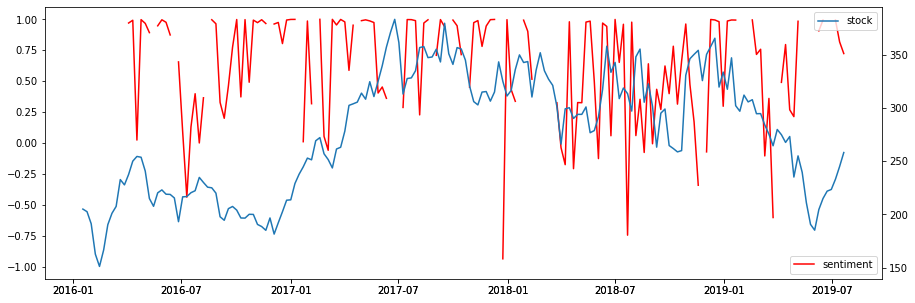

In [17]:
quick_graph(tesla_master)

Between the gaps in sentiment analysis values and the stronger underlying trends in the stock values, it's immediately clear if this is a useful indicator. I'd rather have seen something really clear! No matter, this is just the exploration phase, we'll see if it is any use going forward.

For now, it's worth just reading in some of the other companies and seeing what they're like.

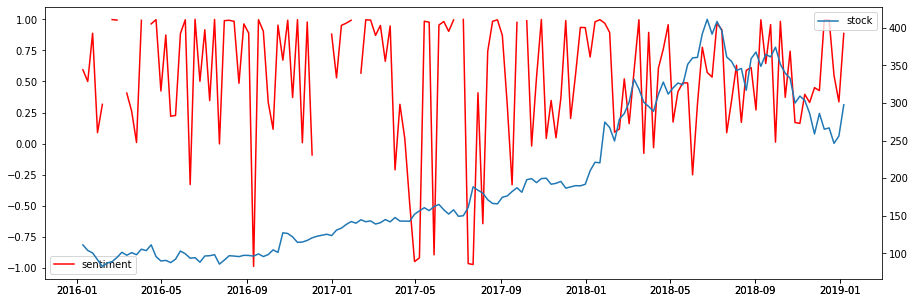

In [19]:
netflix_2016 = pd.read_csv('nyt_text/Netflix_2016_strict.csv')
netflix_2017 = pd.read_csv('nyt_text/Netflix_2017_strict.csv')
netflix_2018 = pd.read_csv('nyt_text/Netflix_2018_strict.csv')
netflix = [netflix_2016, netflix_2017, netflix_2018]
netflix_stock = pd.read_csv('stock_data/NFLX.csv')
netflix_master = formatter(netflix,netflix_stock,'netflix',2)
quick_graph(netflix_master)

The overall trend for Netflix looks much stronger than any short term sentiment swings!

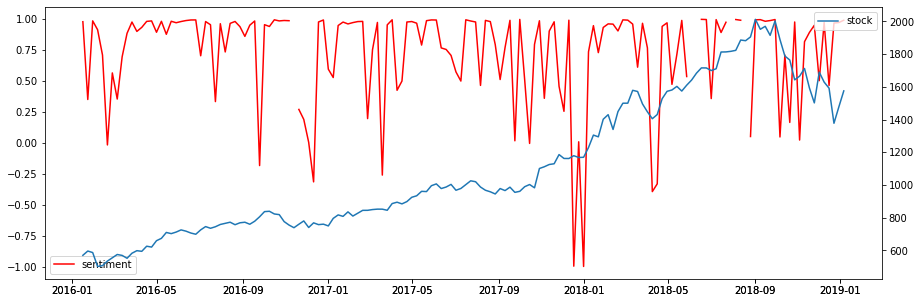

In [20]:
amazon_2016 = pd.read_csv('nyt_text/Amazon_2016_strict.csv')
amazon_2017 = pd.read_csv('nyt_text/Amazon_2017_strict.csv')
amazon_2018 = pd.read_csv('nyt_text/Amazon_2018_strict.csv')
amazon = [amazon_2016, amazon_2017, amazon_2018]
amazon_stock = pd.read_csv('stock_data/AMZN.csv')
amazon_master = formatter(amazon,amazon_stock,'amazon',2)
quick_graph(amazon_master)